In [2]:
import sys
sys.path.append("../") # go to parent dir to allow imports

In [3]:
from models import mnist_model
from tensorflow.examples.tutorials.mnist import input_data

import tensorflow as tf
import numpy as np
import numpy.ma as ma
from scipy.stats import bernoulli

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

%load_ext autoreload
%autoreload 2

mnist = input_data.read_data_sets("../data/MNIST-data", one_hot=True)

Extracting ../data/MNIST-data/train-images-idx3-ubyte.gz
Extracting ../data/MNIST-data/train-labels-idx1-ubyte.gz
Extracting ../data/MNIST-data/t10k-images-idx3-ubyte.gz
Extracting ../data/MNIST-data/t10k-labels-idx1-ubyte.gz


In [4]:
import imageio

In [5]:
labels = [str(x) for x in range(10)]

def show(img):
    """Displays single mnist digit"""
    plt.imshow(img.reshape([28, 28]), cmap="gray")
    plt.show()
    
def show_with_var(img, prob, var):
    """Display single mnist digit next to the variance per class"""
    fig, axs = plt.subplots(1, 3, figsize=(10,5))
    axs[0].imshow(img.reshape([28, 28]))
    axs[1].bar(labels, prob)
    axs[2].bar(labels, var)
    plt.show()

# Training Dropout model

In [4]:
tf.reset_default_graph()
n_passes=50
dropout_rate=0.3
learning_rate=1e-4
epochs=20000
display_step=2000

mnist = input_data.read_data_sets("../data/MNIST-data", one_hot=True)

x_data = tf.placeholder(tf.float32, shape=[None, 784])
y_data = tf.placeholder(tf.float32, shape=[None, 10])
dropout_rate_data = tf.placeholder(tf.float32)

logits, class_prob = mnist_model.dropout_cnn_mnist_model(x_data, dropout_rate_data)

loss = tf.losses.softmax_cross_entropy(onehot_labels=y_data, logits=logits)
correct_prediction = tf.equal(tf.argmax(class_prob, 1), tf.argmax(y_data, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

optimizer = tf.train.AdamOptimizer(learning_rate)
train_step = optimizer.minimize(loss)

init = tf.global_variables_initializer()
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
sess.run(init)

for epoch in range(epochs):
    batch = mnist.train.next_batch(50)

    sess.run(train_step, feed_dict={x_data: batch[0], y_data: batch[1], dropout_rate_data: 0.5})

    if epoch % display_step == 0:
        print("Epoch {}".format(epoch))
        # cur_loss = sess.run(loss, feed_dict={x_data: batch[0],
        #                                      y_data: batch[1]})
        train_accuracy = sess.run(accuracy, feed_dict={
            x_data: batch[0], y_data: batch[1], dropout_rate_data:0}) # no dropout on single accuracy
        print("Accuracy: {}".format(train_accuracy))
        
        # tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
variable_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="mnist")[:8]
saver = tf.train.Saver(var_list=variable_list)
save_path = saver.save(sess, "mnist_dropout.ckpt")

Extracting ../data/MNIST-data/train-images-idx3-ubyte.gz
Extracting ../data/MNIST-data/train-labels-idx1-ubyte.gz
Extracting ../data/MNIST-data/t10k-images-idx3-ubyte.gz
Extracting ../data/MNIST-data/t10k-labels-idx1-ubyte.gz
Epoch 0
Accuracy: 0.179999992251
Epoch 2000
Accuracy: 1.0
Epoch 4000
Accuracy: 0.959999978542
Epoch 6000
Accuracy: 1.0
Epoch 8000
Accuracy: 1.0
Epoch 10000
Accuracy: 0.960000038147
Epoch 12000
Accuracy: 0.980000019073
Epoch 14000
Accuracy: 1.0
Epoch 16000
Accuracy: 1.0
Epoch 18000
Accuracy: 1.0


# Training Bootstrap model

In [4]:
tf.reset_default_graph()
n_heads = 5
dropout_rate=0.3
learning_rate=1e-4
epochs=20000
display_step=50

mnist = input_data.read_data_sets("../data/MNIST-data", one_hot=True)

x_data = tf.placeholder(tf.float32, shape=[None, 784])
y_data = tf.placeholder(tf.float32, shape=[None, 10])
dropout_rate_data = tf.placeholder(tf.float32)

heads = mnist_model.dropout_cnn_mnist_model(x_data, dropout_rate_data)
optimizer = tf.train.AdamOptimizer(learning_rate)

Extracting ../data/MNIST-data/train-images-idx3-ubyte.gz
Extracting ../data/MNIST-data/train-labels-idx1-ubyte.gz
Extracting ../data/MNIST-data/t10k-images-idx3-ubyte.gz
Extracting ../data/MNIST-data/t10k-labels-idx1-ubyte.gz


In [5]:
loss_per_head = []
train_per_head = []
accuracy_per_head = []
for head in heads:
    logits, class_prob = head  # unpack
    loss = tf.losses.softmax_cross_entropy(onehot_labels=y_data, logits=logits)
    loss_per_head.append(loss)
    train_per_head.append(optimizer.minimize(loss))
    
    correct_prediction = tf.equal(tf.argmax(class_prob, 1), tf.argmax(y_data, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    accuracy_per_head.append(accuracy)
    
#loss = tf.losses.softmax_cross_entropy(onehot_labels=y_data, logits=logits)
#correct_prediction = tf.equal(tf.argmax(class_prob, 1), tf.argmax(y_data, 1))
#accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

rv = bernoulli(0.5)
mask = rv.rvs(size=(n_heads, 50)) # x is the length

init = tf.global_variables_initializer()
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
sess.run(init)

# masked is defined only for the most recent batch
for epoch in range(epochs):
    
    batch = mnist.train.next_batch(50)
    x = batch[0]
    y = batch[1]
    
    for i, train_step in enumerate(train_per_head):
        masked_x = x[mask[i] == 1, :]
        masked_y = y[mask[i] == 1, :]
        sess.run(train_step, feed_dict={x_data: masked_x, y_data: masked_y, dropout_rate_data: 0.5})
    
    if epoch % display_step == 0:
        print("Epoch {}".format(epoch))
        for i, a in enumerate(accuracy_per_head):
            cur_acc = sess.run(a, feed_dict={x_data: x, y_data: y, dropout_rate_data: 0.5})
            print("Head {}: Accuracy: {}".format(i, cur_acc))

        #train_accuracy = sess.run(accuracy, feed_dict={
        #    x_data: batch[0], y_data: batch[1], dropout_rate_data:0}) # no dropout on single accuracy
        #print("Accuracy: {}".format(train_accuracy))
        
        # tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
    variable_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="mnist")[:8]
    saver = tf.train.Saver(var_list=variable_list)
    save_path = saver.save(sess, "mnist_bootstrap.ckpt")

# Training Combined Model

![grafik.png](attachment:grafik.png)

In [6]:
tf.reset_default_graph()
dropout_rate=0.3
learning_rate=1e-4
epochs=20000
display_step=2000
T = 20 # Number of Monte Carlo Integration steps for adding noise to the uncertainty

x_data = tf.placeholder(tf.float32, shape=[None, 784])
y_data = tf.placeholder(tf.float32, shape=[None, 10])   # only contains correct label, shape[None] 
dropout_rate_data = tf.placeholder(tf.float32)

# uncertainty (sigma) is per logit
logits, props, uncertainty = mnist_model.combined_cnn_mnist_model(x_data, dropout_rate_data)

batch_size = tf.shape(logits)[0]

eps = tf.random_normal([batch_size, T, 10])
logits_T = tf.tile(tf.reshape(logits, [-1, 1, 10]), [1, T, 1])
uncertainty_T = tf.tile(tf.reshape(uncertainty, [-1, 1, 10]), [1, T, 1])


# Combined loss from What Uncertainties do we need
xi = logits_T + uncertainty_T * eps
y = tf.tile(tf.reshape(y_data, [-1, 1, 10]), [1, T, 1])
onehot_logit = tf.reduce_sum(xi * y, axis=2)
loss = tf.reduce_sum(-tf.log(tf.reduce_mean(tf.exp(onehot_logit - tf.reduce_logsumexp(xi, axis=2)), axis=1)))

# Aleatoric Uncertainty loss
#loss = tf.losses.softmax_cross_entropy(onehot_labels=y, logits=xi)

#l = onehot_logit - tf.reduce_logsumexp(xi, axis=2)

optimizer = tf.train.AdamOptimizer(learning_rate)
train_step = optimizer.minimize(loss)

init = tf.global_variables_initializer()
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
sess.run(init)

for epoch in range(epochs):
    batch = mnist.train.next_batch(50)
    sess.run(train_step, feed_dict={x_data: batch[0], y_data: batch[1], dropout_rate_data: 0.5})

    if epoch % display_step == 0:
        print("Epoch {}".format(epoch))
        # cur_loss = sess.run(loss, feed_dict={x_data: batch[0],
        #                                      y_data: batch[1]})
        train_accuracy = sess.run(loss, feed_dict={
            x_data: batch[0], y_data: batch[1], dropout_rate_data:0}) # no dropout on single accuracy
        print("Accuracy: {}".format(train_accuracy))
        
variable_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="mnist")[:10]
saver = tf.train.Saver(var_list=variable_list)
save_path = saver.save(sess, "mnist_combined.ckpt")

Epoch 0
Accuracy: 2.26391482353
Epoch 2000
Accuracy: 0.18221488595
Epoch 4000
Accuracy: 0.113076582551
Epoch 6000
Accuracy: 0.148344576359
Epoch 8000
Accuracy: 0.0655926764011
Epoch 10000
Accuracy: 0.0806975513697
Epoch 12000
Accuracy: 0.0791413784027
Epoch 14000
Accuracy: 0.0218307301402
Epoch 16000
Accuracy: 0.0398176498711
Epoch 18000
Accuracy: 0.0348564088345


In [20]:
adv_img = imageio.imread("adv_img.png").reshape(784)
img = imageio.imread("img.png").reshape(784)
ticks = [str(x) for x in range(10)]

In [32]:
tf.reset_default_graph()
dropout_rate=0.3

x_data = tf.placeholder(tf.float32, 784)
dropout_rate_data = tf.placeholder(tf.float32)

# uncertainty (sigma) is per logit
logits,props, uncertainty = mnist_model.combined_cnn_mnist_model(x_data, dropout_rate_data)

init = tf.global_variables_initializer()
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
sess.run(init)

variable_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="mnist")[:10]
saver = tf.train.Saver(var_list=variable_list)
saver.restore(sess, "mnist_combined.ckpt")

def combined_inference(img):
    uncertainties = []
    ys = []
    for i in range(50):
        ys.append(sess.run(props, feed_dict={x_data: img, dropout_rate_data: 0.5})[0])
        uncertainties.append(sess.run(tf.square(uncertainty), feed_dict={x_data: img,
                                                                         dropout_rate_data: 0.5})[0])
    fig, axs = plt.subplots(2, 3, figsize=[15, 5])
    fig.suptitle("Adversarial Attack in Combined Network - {}".format(np.mean(entropies)), fontsize=16)
    axs[0, 0].bar(ticks, np.array(ys).var(axis=0))
    axs[0, 0].set_title("Var")
    axs[0, 1].bar(ticks, np.array(ys).mean(axis=0))
    axs[0, 1].set_title("Mean")
    axs[0, 2].imshow(img.reshape(28, 28), cmap="gray")
    
#    fig, axs = plt.subplots(1, 3, figsize=[15, 5])
    axs[1, 0].bar(ticks, np.array(uncertainties).var(axis=0))
    axs[1, 0].set_title("Uncertainty Variance")
    axs[1, 1].bar(ticks, np.array(uncertainties).mean(axis=0))
    axs[1, 1].set_title("Uncertainty Mean")
    axs[1, 2].imshow(img.reshape(28, 28), cmap="gray")
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    
#combined_inference(np.random.uniform(size=(784)))
#combined_inference(adv_img)

INFO:tensorflow:Restoring parameters from mnist_combined.ckpt


## Evaluation and display wrongly classified

Correct: 9
Predicted: 4


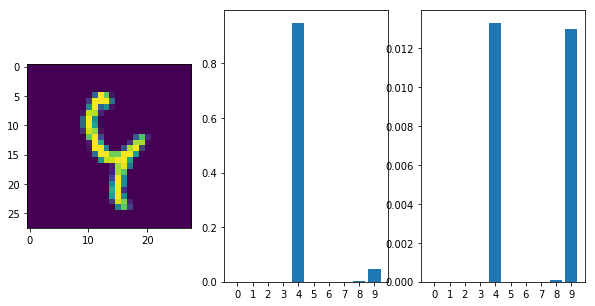

Correct: 7
Predicted: 9


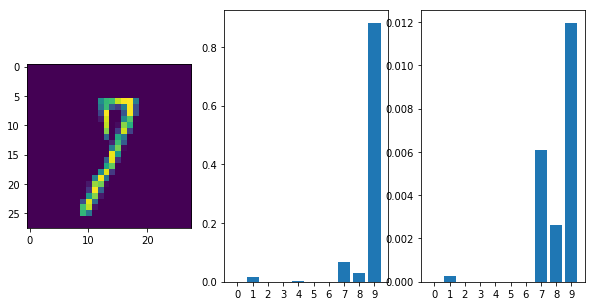

Correct: 9
Predicted: 5


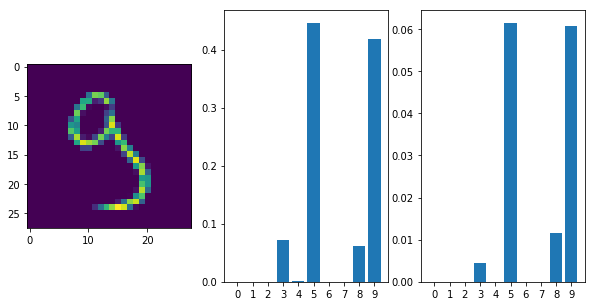

Correct: 0
Predicted: 6


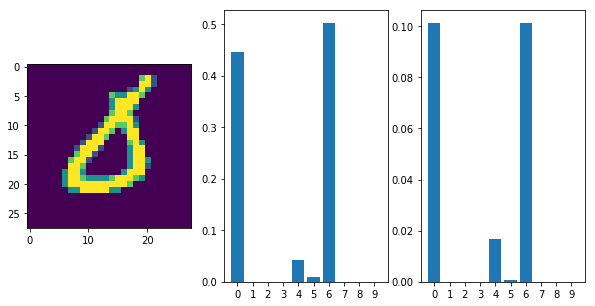

Correct: 6
Predicted: 0


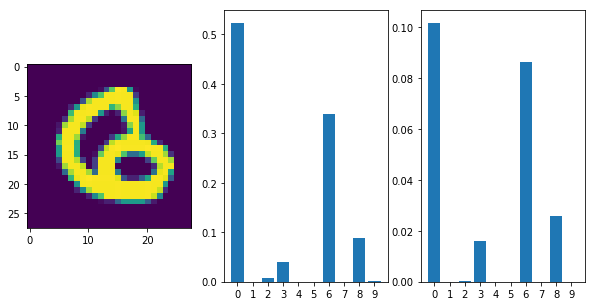

In [8]:
x_test = mnist.test.images
y_test = mnist.test.labels


results = []
for i in xrange(10):
    x_batch, y_batch = mnist.test.next_batch(100)
    # Use tile instead of repeat, because np.repeat flattens results
    x_batch_multipass = np.tile(x_batch, n_passes).reshape(-1, 784)


    pred_y_multipass = sess.run(class_prob, feed_dict={
        x_data: x_batch_multipass, dropout_rate_data: 0.5})

    pred_y_multipass = pred_y_multipass.reshape(-1, n_passes, 10)
    pred_y_mean = pred_y_multipass.mean(axis=1)
    pred_y_var = pred_y_multipass.var(axis=1)

    acc = sess.run(accuracy, feed_dict={
        x_data: x_batch, y_data:y_batch, dropout_rate_data: 0.5})
    
    wrong_idx = np.where(np.equal(np.argmax(y_batch, axis=1), np.argmax(pred_y_mean, axis=1)) == False)[0]
    if len(wrong_idx) > 0:
        for idx in np.nditer(wrong_idx):
            print("Correct: " + str(np.argmax(y_batch[idx])))
            print("Predicted: " + str(np.argmax(pred_y_mean[idx])))
            show_with_var(x_batch[idx], pred_y_mean[idx], pred_y_var[idx])